# Bias, variance, K-fold cross validation and Leaning curves 

This notebook explores the relationship between the number of K folds, the bias, variance and learning curve for a simple toy data set. The code in python was used to generate the plots and simulations used for the following stats.stackexchange post
- https://stats.stackexchange.com/questions/61546/optimal-number-of-folds-in-k-fold-cross-validation-is-leave-one-out-cv-always/357572?noredirect=1#comment672417_357572

## Question: how to chose K in K-fold cross validation 

### Libraries 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use('seaborn-white')
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold
from sklearn.metrics import mean_squared_error 

from scipy import interpolate

### Viewing the toy data set and degree 4 polynomial regression 

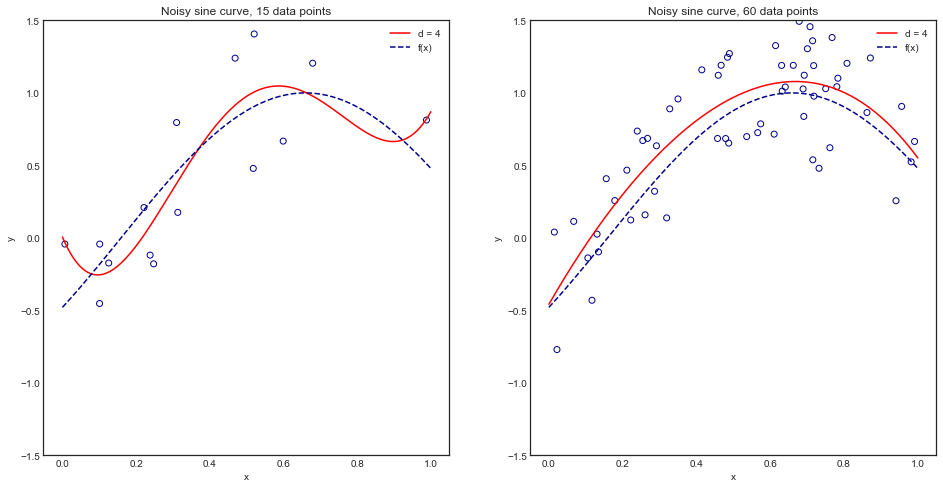

In [274]:
#Utility variables
degs = np.arange(0,11)
degrees = [4]
Train_MSE_list, Test_MSE_list = [], []

#Initializing noisy non linear data
n = 10000
x = np.linspace(0,1,n)
x_plot = np.linspace(0,1,10*n)
noise = np.random.uniform(-.5,.5, size = n)
y = np.sin(x * 1 * np.pi  - .5)  
y_noise = y + noise
Y = (y + noise).reshape(-1,1)
X = x.reshape(-1,1)

rs = ShuffleSplit(n_splits=1, train_size = 15, test_size=5)
rs.get_n_splits(X)
    
for train_index, test_index in rs.split(X):
    X_train, X_test, y_train, y_test = X[train_index],X[test_index],Y[train_index], Y[test_index] 


#Setup plot figures
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 2, 1)

for d in degs:
    #Create an sklearn pipeline, fit and plot result
    pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures(degree=d, include_bias=True, interaction_only=False)),
     ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])
    
    pipeline.fit(X_train,y_train)
    
    Train_MSE = mean_squared_error(y_train, pipeline.predict(X_train))
    Test_MSE = mean_squared_error(y_test, pipeline.predict(X_test))
    Train_MSE_list.append(Train_MSE)
    Test_MSE_list.append(Test_MSE)

    if d in degrees: 
        plt.plot(x_plot, pipeline.predict(x_plot.reshape(-1,1)), label = 'd = {}'.format(d), color = 'red') 


#First plot left hand side
ax.plot(x,y,color = 'darkblue',linestyle = '--', label = 'f(x)')
ax.scatter(X_train,y_train, facecolors = 'none', edgecolor = 'darkblue')
ax.set_title('Noisy sine curve, 15 data points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim(-1.5,1.5)
ax.legend()

#========================== RHS plot ====================#


rs = ShuffleSplit(n_splits=1, train_size = 60, test_size=15)
rs.get_n_splits(X)
    
for train_index, test_index in rs.split(X):
    X_train, X_test, y_train, y_test = X[train_index],X[test_index],Y[train_index], Y[test_index] 


ax = fig.add_subplot(1, 2, 2)

for d in degs:
    #Create an sklearn pipeline, fit and plot result
    pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures(degree=d, include_bias=True, interaction_only=False)),
     ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])
    
    pipeline.fit(X_train,y_train)
    
    Train_MSE = mean_squared_error(y_train, pipeline.predict(X_train))
    Test_MSE = mean_squared_error(y_test, pipeline.predict(X_test))
    Train_MSE_list.append(Train_MSE)
    Test_MSE_list.append(Test_MSE)

    if d in degrees: 
        plt.plot(x_plot, pipeline.predict(x_plot.reshape(-1,1)), label = 'd = {}'.format(d), color = 'red') 


#First plot left hand side
ax.plot(x,y,color = 'darkblue',linestyle = '--', label = 'f(x)')
ax.scatter(X_train,y_train, facecolors = 'none', edgecolor = 'darkblue')
ax.set_title('Noisy sine curve, 60 data points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim(-1.5,1.5)
ax.legend()

plt.show()

### Learning curve 

Text(0.5,1,'1 - Error (MSE) vs Training size ')

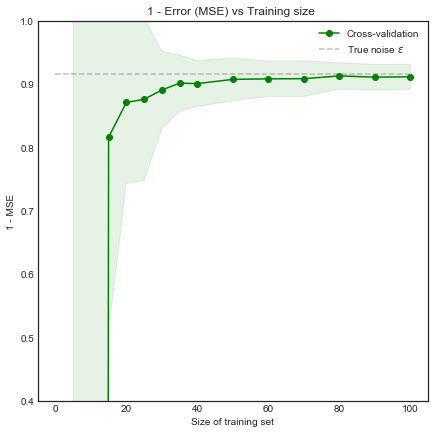

In [218]:
#Utility variables
CV_Mean_MSE, CV_Std_MSE = [],[]
train_sizes=np.array([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
test_sizes = np.array([1,2,3,4,5,6,7,8,10,12,14,16,18,20])


for s in range(len(train_sizes)):

    Test_MSE_list = []
    rs = ShuffleSplit(n_splits=300, train_size = train_sizes[s], test_size=test_sizes[s])
    rs.get_n_splits(X)
    

    for train_index, test_index in rs.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test, y_train, y_test = X[train_index],X[test_index],Y[train_index], Y[test_index] 

        pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures(degree=4, include_bias=True, interaction_only=False)),
         ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])
        pipeline.fit(X_train,y_train)

        #Inner loop results
        Test_MSE_list.append(mean_squared_error(y_test, pipeline.predict(X_test)))
    
    #Calculating loop results: mean and std
    CV_Mean_MSE.append(np.mean(Test_MSE_list))
    CV_Std_MSE.append(np.std(Test_MSE_list))

#Converting to numpy for convenience
CV_Mean_MSE = np.asarray(CV_Mean_MSE)
CV_Std_MSE = np.asarray(CV_Std_MSE)


#Plotting
plt.figure(figsize = (7,7))
plt.fill_between(train_sizes, 1 - (CV_Mean_MSE - CV_Std_MSE),
                 1 - (CV_Mean_MSE + CV_Std_MSE), alpha=0.1, color="g")

plt.plot(train_sizes, 1 - CV_Mean_MSE, 'o-', color="g",
         label="Cross-validation")

plt.hlines(1 - 1/12 , 0,100, linestyle = '--', color = 'gray', alpha = .5, label = 'True noise $\epsilon$')
plt.legend(loc="best")
plt.ylim(0.4,1)
plt.ylabel('1 - MSE')
plt.xlabel('Size of training set')
plt.title('1 - Error (MSE) vs Training size ')



# Approach 1) Re-sampling with replacement from 10,000 points at each bootstrap iteration



- Iterate i times (e.g. 100 or 200 times). At each iteration, change the data set by sampling N data points from the original dataset
    - For each dataset i: Perform K fold CV for one value of K
    - Calculate the mean MSE of the K fold CV
- Calculate the mean and standard deviation across the i iterations for the same value of K
- Repeat the above steps for different k = 5.. N


## Small data set: Increasing K improves bias slightly
### Small dataset  - 40 points

In [283]:
#Utility variables
CV_Mean_MSE_small, CV_Var_MSE_small = [],[]
k_folds_range = np.array([2,4,6,8,10,15,20,25,29,35,39])

for k in k_folds_range:
    #Reset list at start of loop
    i_Mean_MSE = []
    
    #Repeat experiment i times
    for i in range(300):
        #Reset list at start of loop        
        Kfold_MSE_list = []
        
        #Resample with replacement from original dataset
        rs = ShuffleSplit(n_splits=1, train_size = 40, test_size=1)
        rs.get_n_splits(X)
        for subset_index, _ in rs.split(X):
            X_subset, Y_subset, = X[subset_index],Y[subset_index]
        
        #Loop over kfold splits
        kf = KFold(n_splits = k)
        for train_index, test_index in kf.split(X_subset):
            X_train, X_test = X_subset[train_index], X_subset[test_index]
            y_train, y_test = Y_subset[train_index], Y_subset[test_index]
            
            #Fit model on X_train
            pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures(degree=4, include_bias=True, interaction_only=False)),
             ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])
            pipeline.fit(X_train,y_train)
            
            #Store each Kfold MSE values on X_test
            Kfold_MSE_list.append(mean_squared_error(y_test, pipeline.predict(X_test)))
            
        #Average over the K folds for a single "i" iteration
        i_Mean_MSE.append(np.mean(Kfold_MSE_list))
    
    #Average and std for a particular k value over all i iterations
    CV_Mean_MSE_small.append(np.mean(i_Mean_MSE))
    CV_Var_MSE_small.append(np.var(i_Mean_MSE, ddof = 1))
    
#Convert to numpy for convenience
CV_Mean_MSE_small  = np.asarray(CV_Mean_MSE_small)
CV_Var_MSE_small  = np.asarray(CV_Var_MSE_small)
CV_Std_MSE_small = np.sqrt(CV_Var_MSE_small)

Text(0.5,1,'1 - MSE vs Number of Kfolds: 40 data points, 300 iterations bootstrap ')

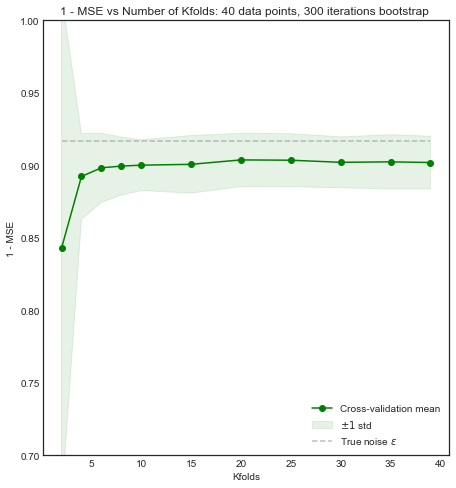

In [287]:
#Plotting result - LHS - 1 - MSE
fig = plt.figure(figsize=(16,8))
fig.add_subplot(1, 2, 1)
k_folds_range = np.array([2,4,6,8,10,15,20,25,30,35,39])

plt.fill_between(k_folds_range, 1 - (CV_Mean_MSE_small - CV_Std_MSE_small),
                 1 - (CV_Mean_MSE_small + CV_Std_MSE_small), alpha=0.1, color="g", label = '$\pm 1$ std')

plt.plot(k_folds_range, 1 - CV_Mean_MSE_small, 'o-', color="g",
         label="Cross-validation mean")

plt.hlines(1 - 1/12 , min(k_folds_range),max(k_folds_range), linestyle = '--', color = 'gray', alpha = .5, label = 'True noise $\epsilon$')
plt.legend(loc="lower right"), 
plt.ylim(0.7,1)
plt.ylabel('1 - MSE'), plt.xlabel('Kfolds')
plt.title('1 - MSE vs Number of Kfolds: 40 data points, 300 iterations bootstrap ')


### Printing the standard deviation for each K value 

In [285]:
pd.DataFrame(data = {'K = ':k_folds_range,'Mean MSE': CV_Mean_MSE_small,'Std MSE': CV_Std_MSE_small })


,K =,Mean MSE,Std MSE
0,2,0.157134,0.175537
1,4,0.107629,0.029576
2,6,0.101669,0.023816
3,8,0.100500,0.019984
4,10,0.099851,0.017532
5,15,0.099272,0.019867
6,20,0.096221,0.018406
7,25,0.096428,0.018322
8,30,0.097886,0.017572
9,35,0.097560,0.018720


### Viewing variance as a function of k 

Text(0.5,1,'Var MSE vs Number of Kfolds: 40 data points, 100 iterations bootstrap ')

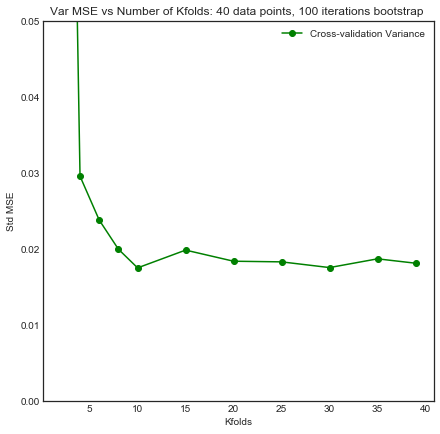

In [286]:
plt.figure(figsize = (7,7))

plt.plot(k_folds_range, CV_Std_MSE_small, 'o-', color="g",
         label="Cross-validation Variance")

plt.legend(loc="best")
plt.ylabel('Std MSE')
plt.xlabel('Kfolds')
plt.ylim(0,.05)
plt.title('Var MSE vs Number of Kfolds: 40 data points, 100 iterations bootstrap ')

## Large dataset: Increasing K increases the variance, constant bias
### Large data set: 200 points

In [277]:
#Utility variables
CV_Mean_MSE_larger, CV_Std_MSE_larger = [],[]
k_folds_range = np.array([5,20,40,80,125,175,199])

for k in k_folds_range:
    #Reset list at start of loop
    i_Mean_MSE = []
    
    #Repeat experiment i times
    for i in range(50):
        #Reset list at start of loop        
        Kfold_MSE_list = []
        
        #Resample with replacement from original dataset
        rs = ShuffleSplit(n_splits=1, train_size = 200, test_size=1)
        rs.get_n_splits(X)
        for subset_index, _ in rs.split(X):
            X_subset, Y_subset, = X[subset_index],Y[subset_index]
        
        #Loop over kfold splits
        kf = KFold(n_splits = k)
        for train_index, test_index in kf.split(X_subset):
            X_train, X_test = X_subset[train_index], X_subset[test_index]
            y_train, y_test = Y_subset[train_index], Y_subset[test_index]
            
            #Fit model on X_train
            pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures(degree=4, include_bias=True, interaction_only=False)),
             ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])
            pipeline.fit(X_train,y_train)
            
            #Store each Kfold MSE values on X_test
            Kfold_MSE_list.append(mean_squared_error(y_test, pipeline.predict(X_test)))
            
        #Average over the K folds for a single "i" iteration
        i_Mean_MSE.append(np.mean(Kfold_MSE_list))
    
    #Average and std for a particular k value over all i iterations
    CV_Mean_MSE_larger.append(np.mean(i_Mean_MSE))
    CV_Std_MSE_larger.append(np.std(i_Mean_MSE))
    
#Convert to numpy for convenience
CV_Mean_MSE_larger  = np.asarray(CV_Mean_MSE_larger)
CV_Std_MSE_larger  = np.asarray(CV_Std_MSE_larger)

Text(0.5,1,'1 - MSE vs Number of Kfolds: 200 data points ')

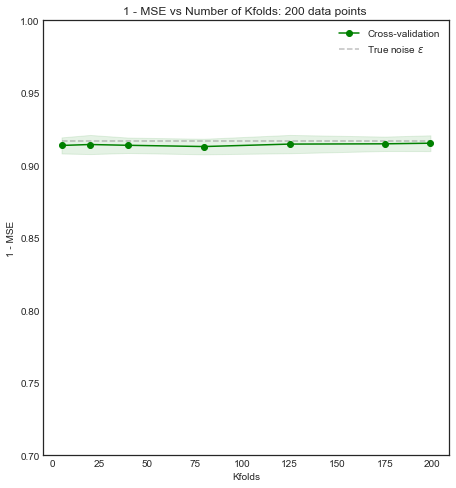

In [278]:
#Plotting result - LHS
fig = plt.figure(figsize=(16,8))
fig.add_subplot(1, 2, 1)
k_folds_range = np.array([5,20,40,80,125,175,199])
plt.fill_between(k_folds_range, 1 - (CV_Mean_MSE_larger - CV_Std_MSE_larger),
                 1 - (CV_Mean_MSE_larger + CV_Std_MSE_larger), alpha=0.1, color="g")

plt.plot(k_folds_range, 1 - CV_Mean_MSE_larger, 'o-', color="g",
         label="Cross-validation")

plt.hlines(1 - 1/12 , min(k_folds_range),max(k_folds_range), linestyle = '--', color = 'gray', alpha = .5, label = 'True noise $\epsilon$')
plt.legend(loc="best")
plt.ylim(0.7,1)
plt.ylabel('1 - MSE')
plt.xlabel('Kfolds')
plt.title('1 - MSE vs Number of Kfolds: 200 data points ')



### Printing the standard deviation for each K value 

In [280]:
pd.DataFrame(data = {'K = ':k_folds_range,'Mean MSE': CV_Mean_MSE_larger,'Std MSE': CV_Std_MSE_larger })


,K =,Mean MSE,Std MSE
0,5,0.086242,0.005556
1,20,0.085608,0.006608
2,40,0.086142,0.005320
3,80,0.087002,0.005372
4,125,0.085311,0.006317
5,175,0.085118,0.004977
6,199,0.084704,0.005453


Text(0.5,1,'Var MSE vs Number of Kfolds: 200 data points, 100 iterations bootstrap ')

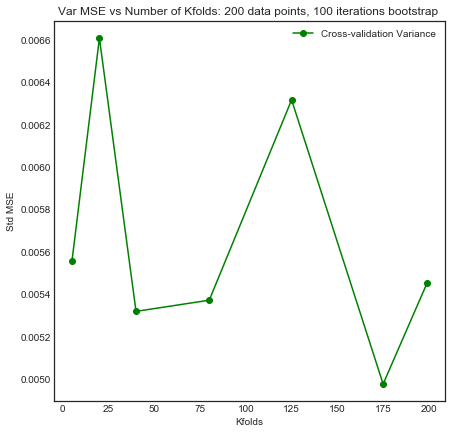

In [281]:
plt.figure(figsize = (7,7))

plt.plot(k_folds_range, CV_Std_MSE_larger, 'o-', color="g",
         label="Cross-validation Variance")

#plt.hlines(1 - 1/12 , min(split_range),max(split_range), linestyle = '--', color = 'gray', alpha = .5, label = 'True noise $\epsilon$')
plt.legend(loc="best")
#plt.ylim(0.8,1)
plt.ylabel('Std MSE')
plt.xlabel('Kfolds')
plt.title('Var MSE vs Number of Kfolds: 200 data points, 100 iterations bootstrap ')

# Approach 2) Repeated K-fold with shuffle = True with the same dataset

- Iterate i times (e.g. 50 times). At each iteration, keep the same dataset but reshuffle it
    - For each i: Perform K fold CV for one value of K
    - Calculate the mean MSE of the K fold CV
- Calculate the mean and standard deviation across the i iterations for the same value of K
- Repeat the above steps for different k = 5.. N

## Small dataset

In [258]:
#Utility variables
CV_Mean_MSE_small, CV_Var_MSE_small = [],[]
k_folds_range = np.array([2,4,6,8,10,15,20,25,29,35,39])

#Subsample from original dataset
rs = ShuffleSplit(n_splits=1, train_size = 40, test_size=1)
rs.get_n_splits(X)
for subset_index, _ in rs.split(X):
    X_subset, Y_subset, = X[subset_index],Y[subset_index]

for k in k_folds_range:
    #Reset list at start of loop
    i_Mean_MSE = []
    
    #Repeat experiment i times
    for i in range(50):
        #Reset list at start of loop        
        Kfold_MSE_list = []
        
        
        #Loop over kfold splits
        kf = KFold(n_splits = k, shuffle = True)
        for train_index, test_index in kf.split(X_subset):
            X_train, X_test = X_subset[train_index], X_subset[test_index]
            y_train, y_test = Y_subset[train_index], Y_subset[test_index]
            
            #Fit model on X_train
            pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures(degree=4, include_bias=True, interaction_only=False)),
             ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])
            pipeline.fit(X_train,y_train)
            
            #Store each Kfold MSE values on X_test
            Kfold_MSE_list.append(mean_squared_error(y_test, pipeline.predict(X_test)))
            
        #Average over the K folds for a single "i" iteration
        i_Mean_MSE.append(np.mean(Kfold_MSE_list))
    
    #Average and std for a particular k value over all i iterations
    CV_Mean_MSE_small.append(np.mean(i_Mean_MSE))
    CV_Var_MSE_small.append(np.var(i_Mean_MSE, ddof = 1))
    
#Convert to numpy for convenience
CV_Mean_MSE_small  = np.asarray(CV_Mean_MSE_small)
CV_Var_MSE_small  = np.asarray(CV_Var_MSE_small)
CV_Std_MSE_small = np.sqrt(CV_Var_MSE_small)

Text(0.5,1,'1 - MSE vs Number of Kfolds: 40 data points, 100 iterations bootstrap ')

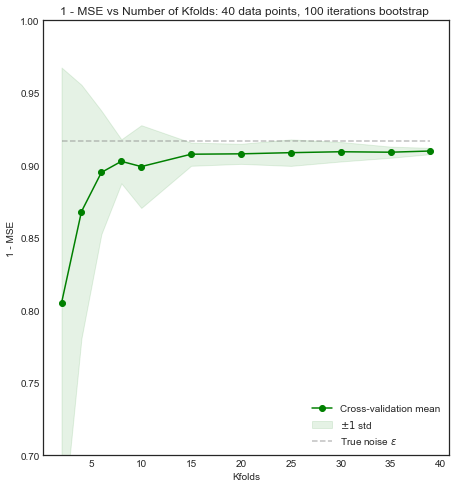

In [259]:
#Plotting result - LHS - 1 - MSE
fig = plt.figure(figsize=(16,8))
fig.add_subplot(1, 2, 1)
k_folds_range = np.array([2,4,6,8,10,15,20,25,30,35,39])

plt.fill_between(k_folds_range, 1 - (CV_Mean_MSE_small - CV_Std_MSE_small),
                 1 - (CV_Mean_MSE_small + CV_Std_MSE_small), alpha=0.1, color="g", label = '$\pm 1$ std')

plt.plot(k_folds_range, 1 - CV_Mean_MSE_small, 'o-', color="g",
         label="Cross-validation mean")

plt.hlines(1 - 1/12 , min(k_folds_range),max(k_folds_range), linestyle = '--', color = 'gray', alpha = .5, label = 'True noise $\epsilon$')
plt.legend(loc="lower right"), 
plt.ylim(0.7,1)
plt.ylabel('1 - MSE'), plt.xlabel('Kfolds')
plt.title('1 - MSE vs Number of Kfolds: 40 data points, 100 iterations bootstrap ')


Text(0.5,1,'Var MSE vs Number of Kfolds: 40 data points, 100 iterations bootstrap ')

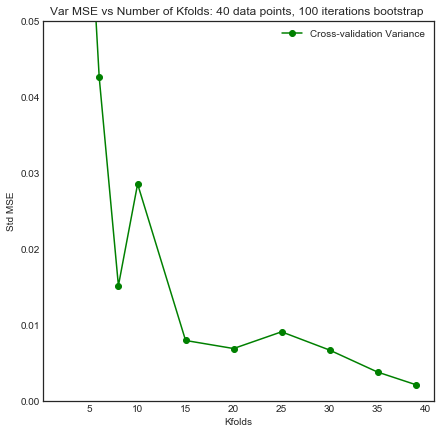

In [260]:
plt.figure(figsize = (7,7))

plt.plot(k_folds_range, CV_Std_MSE_small, 'o-', color="g",
         label="Cross-validation Variance")

plt.legend(loc="best")
plt.ylabel('Std MSE')
plt.xlabel('Kfolds')
plt.ylim(0,.05)
plt.title('Var MSE vs Number of Kfolds: 40 data points, 100 iterations bootstrap ')

## Large dataset 

In [269]:
#Utility variables
CV_Mean_MSE_larger, CV_Std_MSE_larger = [],[]
k_folds_range = np.array([5,20,40,80,125,175,199])

#Resample with replacement from original dataset
rs = ShuffleSplit(n_splits=1, train_size = 200, test_size=1)
rs.get_n_splits(X)
for subset_index, _ in rs.split(X):
    X_subset, Y_subset, = X[subset_index],Y[subset_index]

for k in k_folds_range:
    #Reset list at start of loop
    i_Mean_MSE = []
    
    #Repeat experiment i times
    for i in range(50):
        #Reset list at start of loop        
        Kfold_MSE_list = []
        
        #Loop over kfold splits
        kf = KFold(n_splits = k, shuffle = True)
        for train_index, test_index in kf.split(X_subset):
            X_train, X_test = X_subset[train_index], X_subset[test_index]
            y_train, y_test = Y_subset[train_index], Y_subset[test_index]
            
            #Fit model on X_train
            pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures(degree=4, include_bias=True, interaction_only=False)),
             ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])
            pipeline.fit(X_train,y_train)
            
            #Store each Kfold MSE values on X_test
            Kfold_MSE_list.append(mean_squared_error(y_test, pipeline.predict(X_test)))
            
        #Average over the K folds for a single "i" iteration
        i_Mean_MSE.append(np.mean(Kfold_MSE_list))
    
    #Average and std for a particular k value over all i iterations
    CV_Mean_MSE_larger.append(np.mean(i_Mean_MSE))
    CV_Std_MSE_larger.append(np.std(i_Mean_MSE))
    
#Convert to numpy for convenience
CV_Mean_MSE_larger  = np.asarray(CV_Mean_MSE_larger)
CV_Std_MSE_larger  = np.asarray(CV_Std_MSE_larger)

Text(0.5,1,'1 - MSE vs Number of Kfolds: 200 data points ')

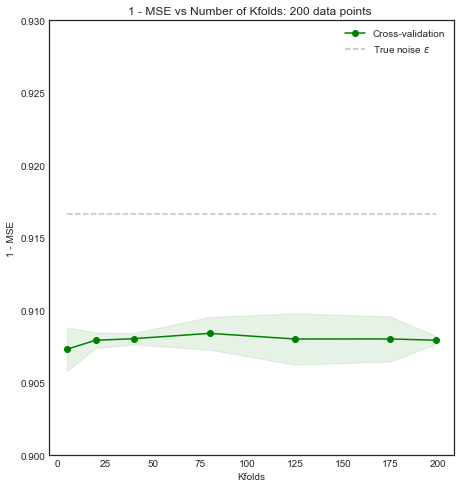

In [270]:
#Plotting result - LHS
fig = plt.figure(figsize=(16,8))
fig.add_subplot(1, 2, 1)
k_folds_range = np.array([5,20,40,80,125,175,199])
plt.fill_between(k_folds_range, 1 - (CV_Mean_MSE_larger - CV_Std_MSE_larger),
                 1 - (CV_Mean_MSE_larger + CV_Std_MSE_larger), alpha=0.1, color="g")

plt.plot(k_folds_range, 1 - CV_Mean_MSE_larger, 'o-', color="g",
         label="Cross-validation")

plt.hlines(1 - 1/12 , min(k_folds_range),max(k_folds_range), linestyle = '--', color = 'gray', alpha = .5, label = 'True noise $\epsilon$')
plt.legend(loc="best")
plt.ylim(0.9,.93)
plt.ylabel('1 - MSE')
plt.xlabel('Kfolds')
plt.title('1 - MSE vs Number of Kfolds: 200 data points ')



Text(0.5,1,'Var MSE vs Number of Kfolds: 200 data points, 50 iterations bootstrap ')

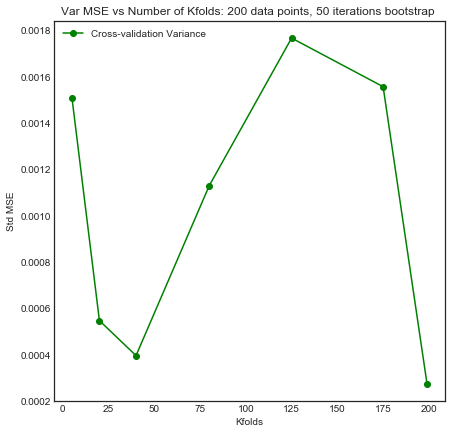

In [273]:
plt.figure(figsize = (7,7))

plt.plot(k_folds_range, CV_Std_MSE_larger, 'o-', color="g",
         label="Cross-validation Variance")

#plt.hlines(1 - 1/12 , min(split_range),max(split_range), linestyle = '--', color = 'gray', alpha = .5, label = 'True noise $\epsilon$')
plt.legend(loc="best")
#plt.ylim(0.8,1)
plt.ylabel('Std MSE')
plt.xlabel('Kfolds')
plt.title('Var MSE vs Number of Kfolds: 200 data points, 50 iterations bootstrap ')

In [272]:
CV_Std_MSE_larger

array([0.0015092 , 0.0005478 , 0.00039666, 0.00112999, 0.00176689,
       0.00155714, 0.00027417])